In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.rl_data_record import RLDataRecord
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [ ]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.id for e in dataset.get_episods(batch_episode_indices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 20000
test_dataset : 200
eval_dataset : 20000
data loader: TRAIN, 500
data loader: TEST, 50
data loader: EVAL, 500


In [ ]:
# for idx, batch_data in enumerate(train_dataloader):
#     batch_episode_indices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_indices)}, batch ids: {[e.id for e in train_dataset.get_episods(batch_episode_indices=batch_episode_indices)]}"
#     )

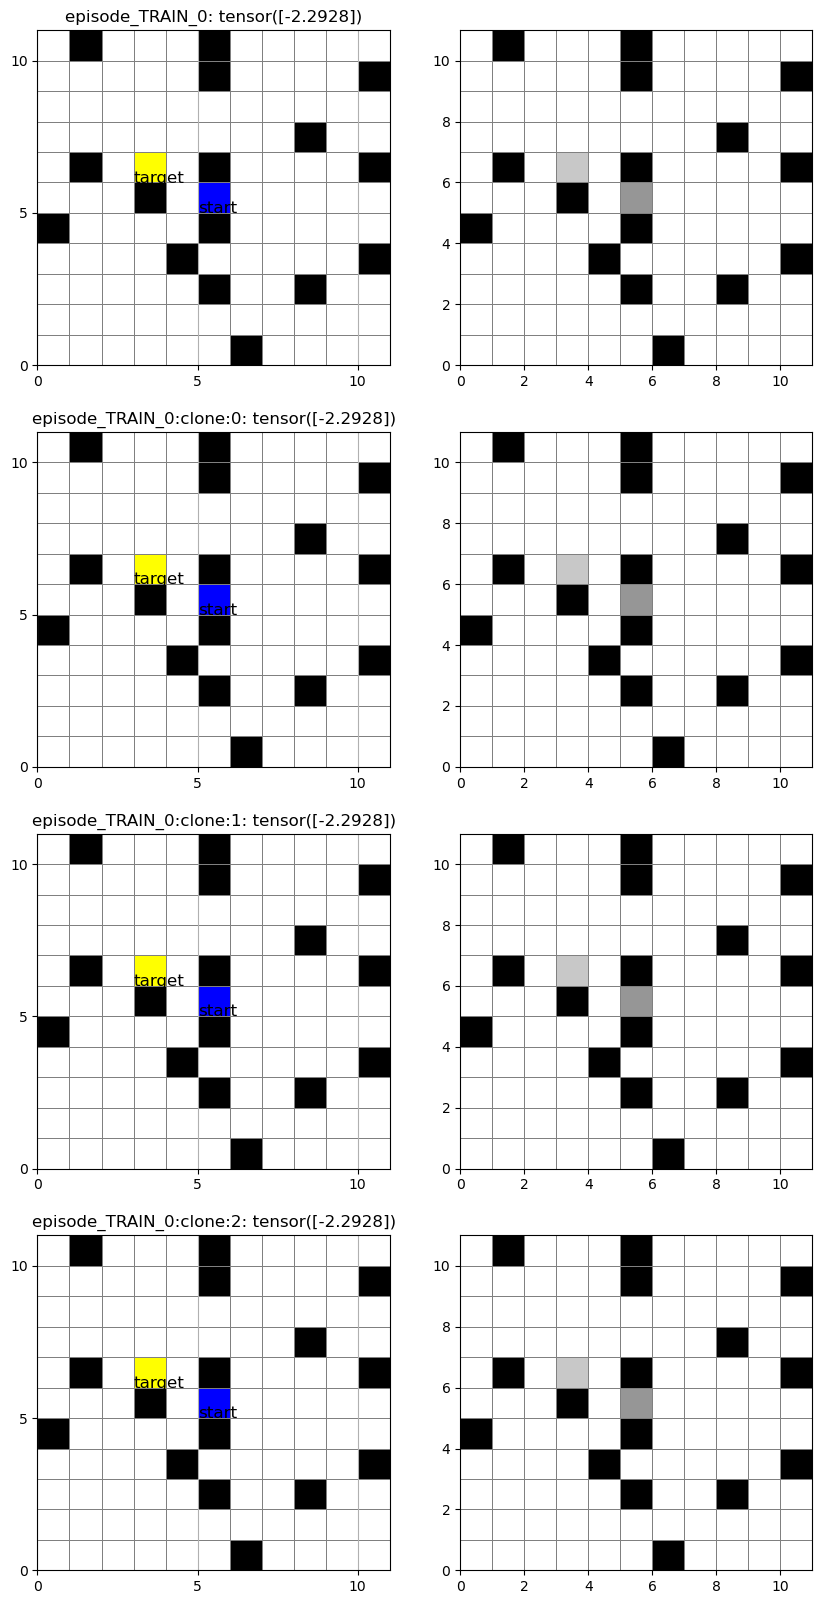

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

step: 0, logits: tensor([[-218.0849,  -74.3751, -207.0034,  520.5236,  -46.8192,  175.7165,
            4.6947,  234.2491,  -22.8061]]), logit_prob: tensor([[0.2027]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([5, 4]), action_history: [tensor(3)]
step: 1, logits: tensor([[-90.7049,  -3.2575, -27.8444, 600.5953, 140.7617, 274.3159, -99.0307,
         242.4906, 194.0036]]), logit_prob: tensor([[0.2052]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([5, 3]), action_history: [tensor(3), tensor(3)]
step: 2, logits: tensor([[-264.2546,  137.2039,   48.5396,  304.3940,   71.6221,   98.0105,
           68.7170, -136.0338,   54.7868]]), logit_prob: tensor([[0.1702]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([5, 2]), action_history: [tensor(3), tensor(3), tensor(3)]
step: 3, logits: tensor([[-225.5807,  102.0499,  114.9678,  172.3489,  185.4360,    7.7265,
         -263.6890,   25.9389,  168.9876]]), logit_prob: te

/Users/chengbai/ml/cheng_git/rf_agent/src/policy.py:28: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  layer.weight = nn.init.kaiming_uniform(layer.weight)


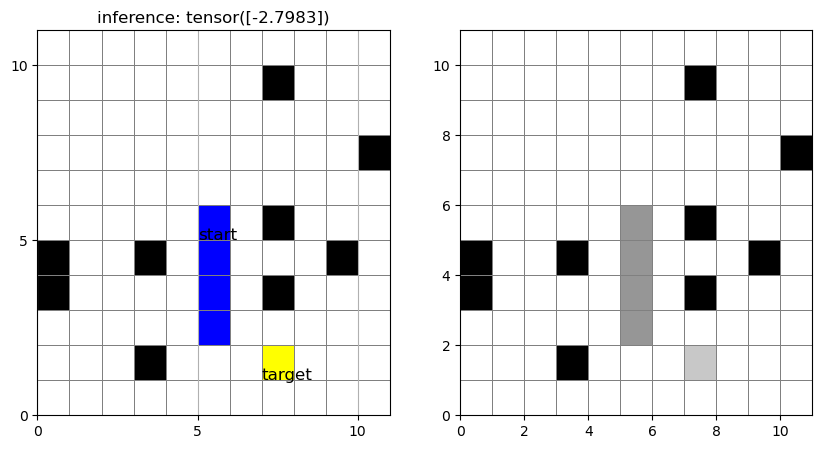

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(
    policy=test_policy, config=config, reward_model=reward_model, steps=5, debug=True
)
# episode.agent.action_history

In [6]:
# np.linalg.norm([8, 6], ord=1)
episode.reward(reward_model=reward_model)

tensor([-2.7983])

# Training Loop
---

In [7]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[-288.2648,  183.2870,  211.4968,  -74.3479,   51.7185,  711.9604,
          -92.6969, 1004.8245,  -58.2734]]), logit_prob: tensor([[0.1993]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([6, 5]), action_history: [tensor(7)]
step: 1, logits: tensor([[ -79.3452,  160.2925,   97.8625, -176.4865, -107.9634,  516.0338,
           14.5141,  700.2770,   24.2785]]), logit_prob: tensor([[0.2020]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([7, 5]), action_history: [tensor(7), tensor(7)]
step: 2, logits: tensor([[ 132.2453,  122.8050,  145.1089,  -40.9261, -160.2032,  438.2658,
           37.8422,  561.8982,  -34.8780]]), logit_prob: tensor([[0.1914]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([8, 5]), action_history: [tensor(7), tensor(7), tensor(7)]
step: 3, logits: tensor([[ -50.9237,  101.5443,  181.7536,  -21.8425,   -8.7019,  577.3102,
         -157.0848,  720.3835,  -38.5836]]), logit

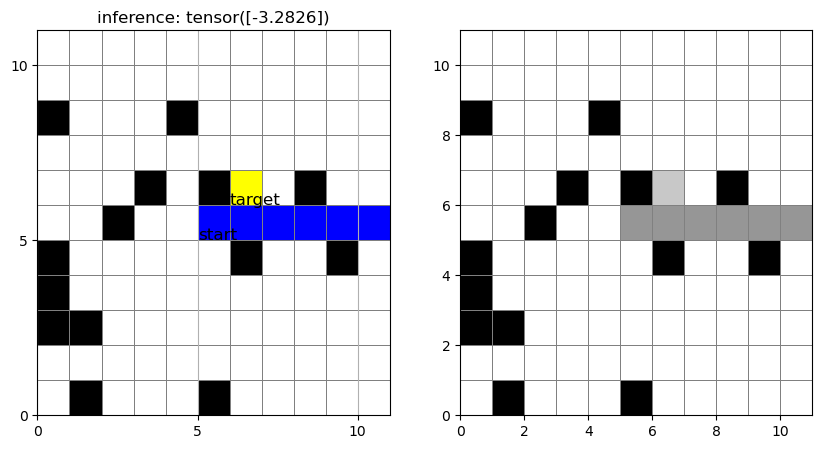

In [8]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(
    policy=policy, config=config, reward_model=reward_model, steps=5, debug=True
)

In [9]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

batch_repeat_sampler: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s, split=EVAL, current_batch_episode_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

TypeError: GRPOTrainer.compute_batch_rewards() missing 1 required positional argument: 'batch_rl_data_record'

In [ ]:
# post model training
episode = inference_and_plot_policy(
    policy=policy,
    config=config,
    reward_model=reward_model,
    steps=40,  # config.episode_steps,
    debug=True,
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

In [ ]:
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

# Evaluate the Model
----

In [ ]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )